In [4]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from xgboost.callback import EarlyStopping
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

In [6]:
import tensorflow as tf
print(tf.__version__)


2.19.0


### 1. Data Exploration

In [7]:
df = pd.read_csv('/content/Egg_Production(1).csv')

In [8]:
df.head()

,Amount_of_chicken,Amount_of_Feeding,Ammonia,Temperature,Humidity,Light_Intensity,Noise,Total_egg_production
0,1626,241.3,19.3,11.9,52.5,380.0,368.5,406
1,124,115.8,12.9,12.9,50.7,264.7,116.0,37
2,9320,217.4,21.2,23.1,65.5,652.7,539.1,3579
3,2291,258.6,17.5,27.0,59.4,481.8,236.3,1114
4,15,62.0,13.6,20.7,71.4,563.4,95.5,8


In [9]:
df.shape

(2000, 8)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Amount_of_chicken     2000 non-null   int64  
 1   Amount_of_Feeding     2000 non-null   float64
 2   Ammonia               1990 non-null   float64
 3   Temperature           1982 non-null   float64
 4   Humidity              1988 non-null   float64
 5   Light_Intensity       1990 non-null   float64
 6   Noise                 1990 non-null   float64
 7   Total_egg_production  2000 non-null   int64  
dtypes: float64(6), int64(2)
memory usage: 125.1 KB


In [11]:
df.describe()

,Amount_of_chicken,Amount_of_Feeding,Ammonia,Temperature,Humidity,Light_Intensity,Noise,Total_egg_production
count,2000.000000,2000.000000,1990.000000,1982.000000,1988.000000,1990.000000,1990.00000,2000.000000
mean,981.526000,175.275750,17.368945,20.473915,62.507746,457.501608,239.57402,323.390000
std,1575.635597,91.011735,7.748096,6.586251,9.891365,140.760819,97.68651,514.606171
min,10.000000,24.600000,2.000000,5.000000,36.900000,97.500000,64.40000,0.000000
25%,106.750000,108.000000,11.900000,16.200000,55.500000,347.050000,159.70000,41.000000
50%,420.000000,156.800000,15.900000,20.500000,61.600000,446.250000,227.70000,140.000000
75%,1003.750000,218.100000,22.100000,24.800000,68.625000,553.875000,296.85000,372.000000
max,9987.000000,675.900000,53.500000,45.000000,95.000000,929.200000,607.30000,5043.000000


In [12]:
df.isnull().sum()

,0
Amount_of_chicken,0
Amount_of_Feeding,0
Ammonia,10
Temperature,18
Humidity,12
Light_Intensity,10
Noise,10
Total_egg_production,0


In [13]:
# Fill missing values with the median
for col in df.columns:
  if df[col].isnull().any():
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

In [14]:
print("Missing values after imputation:")
print(df.isnull().sum())

Missing values after imputation:
Amount_of_chicken       0
Amount_of_Feeding       0
Ammonia                 0
Temperature             0
Humidity                0
Light_Intensity         0
Noise                   0
Total_egg_production    0
dtype: int64


### 2. Data Visualization and Engineering


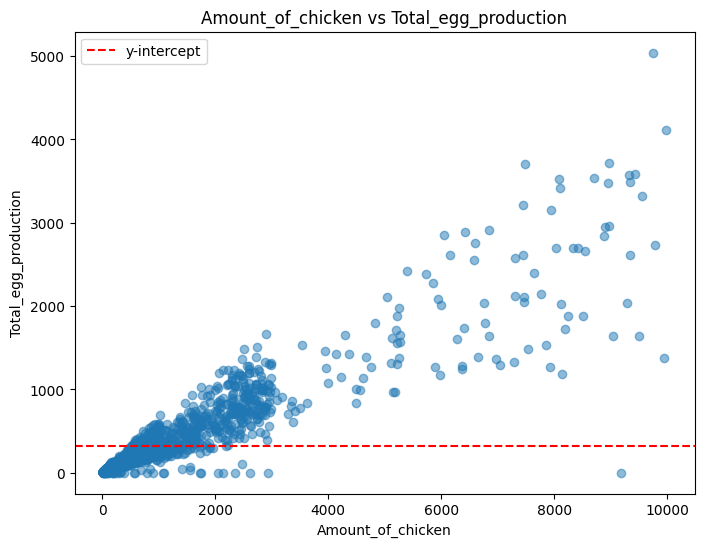

In [15]:
# A scatter plot with y-intercept
plt.figure(figsize=(8, 6))
plt.scatter(df['Amount_of_chicken'], df['Total_egg_production'], alpha=0.5)
plt.axhline(y=df['Total_egg_production'].mean(), color='r', linestyle='--', label='y-intercept')
plt.xlabel('Amount_of_chicken')
plt.ylabel('Total_egg_production')
plt.title('Amount_of_chicken vs Total_egg_production')
plt.legend()
plt.show()


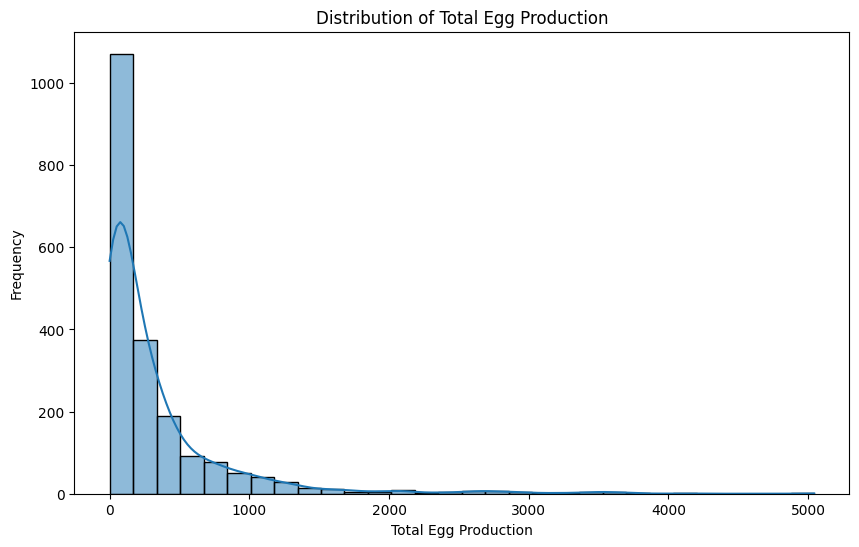

In [16]:
# Create Histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['Total_egg_production'], bins=30, kde=True, edgecolor='black')
plt.xlabel('Total Egg Production')
plt.ylabel('Frequency')
plt.title('Distribution of Total Egg Production')
plt.show()

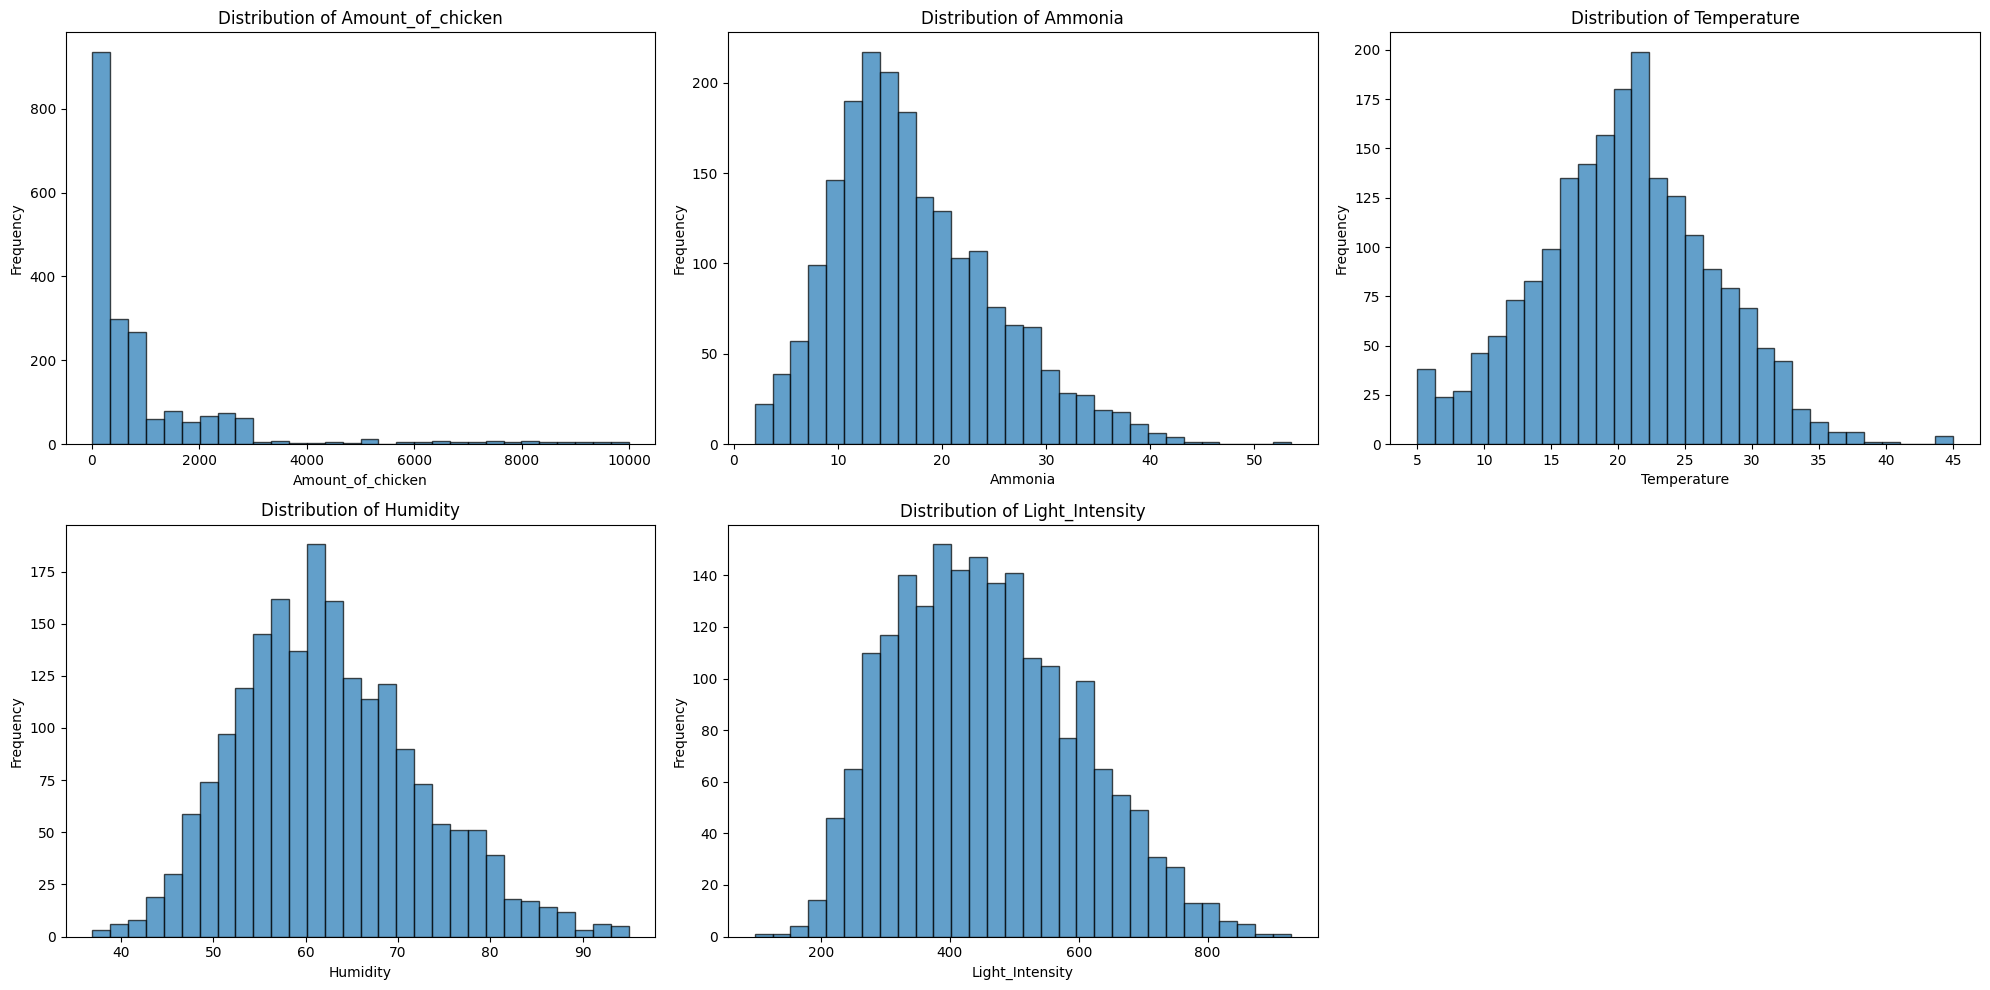

In [17]:
# Data Distribution Visualization
fig, axes = plt.subplots(2, 3, figsize=(20, 10)) # Adjusted subplot size
axes = axes.ravel()

features = df.columns.tolist()
# Exclude 'Noise' and 'Amount_of_Feeding'
features_to_plot = [f for f in features if f not in ['Noise', 'Amount_of_Feeding', 'Total_egg_production']]

for i, feature in enumerate(features_to_plot):
    if i < len(axes):
        axes[i].hist(df[feature], bins=30, alpha=0.7, edgecolor='black')
        axes[i].set_title(f'Distribution of {feature}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(len(features_to_plot), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

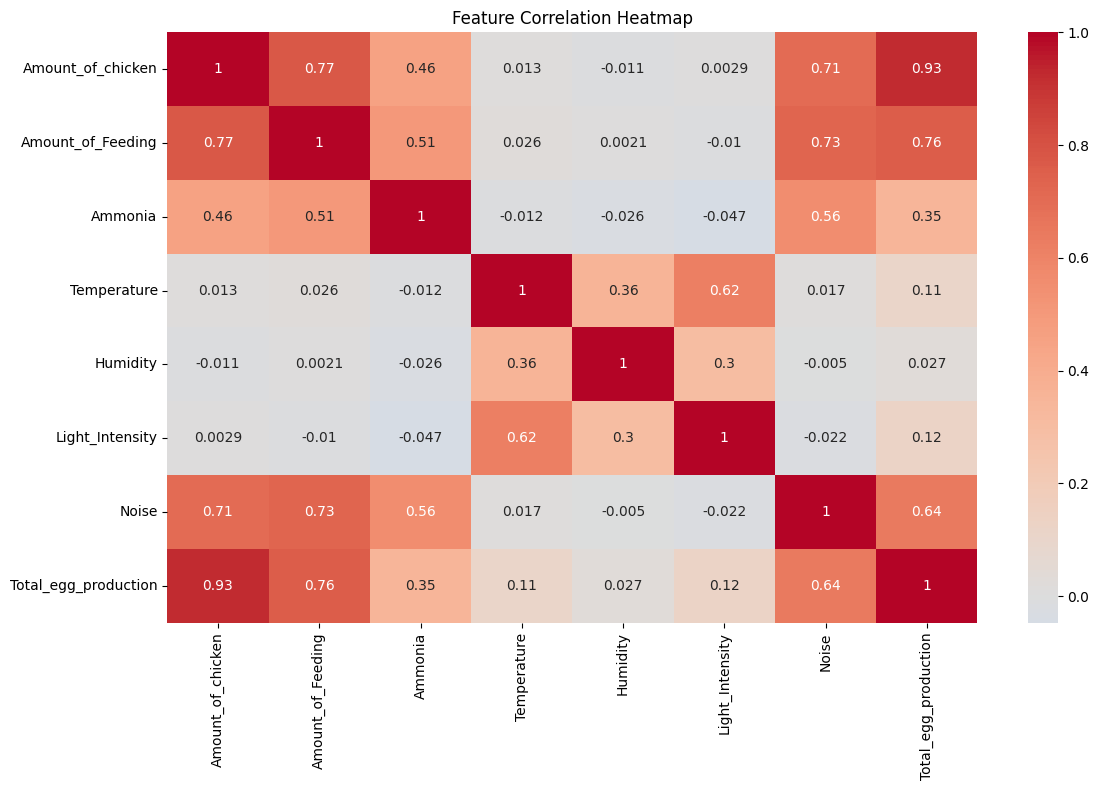

In [18]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

In [19]:
# Calculate correlations with Total_egg_production
all_correlations = df.corr()['Total_egg_production'].abs().sort_values(ascending=False)
print("\nCorrelations with Total_egg_production:")
print(all_correlations)


Correlations with Total_egg_production:
Total_egg_production    1.000000
Amount_of_chicken       0.925873
Amount_of_Feeding       0.760375
Noise                   0.642581
Ammonia                 0.351892
Light_Intensity         0.121409
Temperature             0.111415
Humidity                0.026931
Name: Total_egg_production, dtype: float64


### 3. Train Splitting & Features

In [20]:
# Picking the variables for X
selected_features = [ 'Amount_of_chicken', 'Ammonia', 'Light_Intensity', 'Temperature', 'Humidity', 'Noise' , 'Amount_of_Feeding']

In [21]:
# Prepare data for modeling
X = df.drop('Total_egg_production', axis=1)
y = df['Total_egg_production']

# Split the data into train, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Number of features: {X_train.shape[1]}")

Training set size: 1200
Validation set size: 400
Test set size: 400
Number of features: 7


### 4. XGBoost Model

In [22]:
# XGBoost Model
print("\n" + "=" * 50)
print("XGBOOST MODEL")
print("=" * 50)

# Train XGBoost model with regularization to prevent overfitting
xgb_model = xgb.XGBRegressor(
    n_estimators=50,           # Reduced from 100
    max_depth=3,               # Reduced from 6
    learning_rate=0.05,        # Reduced from 0.1
    reg_alpha=1.0,             # Increased L1 regularization
    reg_lambda=1.0,            # Increased L2 regularization
    subsample=0.8,             # Add subsampling
    colsample_bytree=0.8,      # Add feature subsampling
    min_child_weight=5,        # Add minimum child weight
    random_state=42,
    early_stopping_rounds=10,
)


XGBOOST MODEL


In [23]:
# Train XGBoost with early stopping
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=5, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50,
             n_jobs=None, num_parallel_tree=None, ...)

In [24]:
# Make predictions
xgb_train_pred = xgb_model.predict(X_train)
xgb_test_pred = xgb_model.predict(X_test)

# Calculate metrics
xgb_train_mse = mean_squared_error(y_train, xgb_train_pred)
xgb_test_mse = mean_squared_error(y_test, xgb_test_pred)
xgb_train_r2 = r2_score(y_train, xgb_train_pred)
xgb_test_r2 = r2_score(y_test, xgb_test_pred)
xgb_train_mae = mean_absolute_error(y_train, xgb_train_pred)
xgb_test_mae = mean_absolute_error(y_test, xgb_test_pred)

print(f"Training MSE: {xgb_train_mse:.2f}")
print(f"Test MSE: {xgb_test_mse:.2f}")
print(f"Training R²: {xgb_train_r2:.4f}")
print(f"Test R²: {xgb_test_r2:.4f}")
print(f"Training MAE: {xgb_train_mae:.2f}")
print(f"Test MAE: {xgb_test_mae:.2f}")

Training MSE: 19111.52
Test MSE: 43859.64
Training R²: 0.9242
Test R²: 0.8680
Training MAE: 73.52
Test MAE: 89.45


In [25]:
# Feature importance
xgb_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance (XGBoost):")
print(xgb_importance)


Feature Importance (XGBoost):
             Feature  Importance
0  Amount_of_chicken    0.379925
1  Amount_of_Feeding    0.361511
6              Noise    0.116540
2            Ammonia    0.048536
5    Light_Intensity    0.042050
3        Temperature    0.033752
4           Humidity    0.017686


### 5. Support Vector Machine (SVM) Model

In [26]:
print("\n" + "=" * 50)
print("SUPPORT VECTOR MACHINE (SVM) MODEL")
print("=" * 50)

# Train SVM model with hyperparameter tuning
svm_model = SVR(kernel='rbf', C=100, gamma='scale', epsilon=0.1)
svm_model.fit(X_train_scaled, y_train)


SUPPORT VECTOR MACHINE (SVM) MODEL


SVR(C=100)

In [27]:
# Make predictions
svm_train_pred = svm_model.predict(X_train_scaled)
svm_test_pred = svm_model.predict(X_test_scaled)

In [28]:
# Calculate metrics
svm_train_mse = mean_squared_error(y_train, svm_train_pred)
svm_test_mse = mean_squared_error(y_test, svm_test_pred)
svm_train_r2 = r2_score(y_train, svm_train_pred)
svm_test_r2 = r2_score(y_test, svm_test_pred)
svm_train_mae = mean_absolute_error(y_train, svm_train_pred)
svm_test_mae = mean_absolute_error(y_test, svm_test_pred)

print(f"Training MSE: {svm_train_mse:.2f}")
print(f"Test MSE: {svm_test_mse:.2f}")
print(f"Training R²: {svm_train_r2:.4f}")
print(f"Test R²: {svm_test_r2:.4f}")
print(f"Training MAE: {svm_train_mae:.2f}")
print(f"Test MAE: {svm_test_mae:.2f}")

Training MSE: 66280.26
Test MSE: 108604.35
Training R²: 0.7372
Test R²: 0.6731
Training MAE: 71.28
Test MAE: 94.41


### 6. Decision Tree Regressor Model

In [29]:
# Decision Tree Regressor Model
print("\n" + "=" * 50)
print("DECISION TREE REGRESSOR MODEL")
print("=" * 50)

# Train Decision Tree model with regularization
dt_model = DecisionTreeRegressor(
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42
)


DECISION TREE REGRESSOR MODEL


In [30]:
dt_model.fit(X_train, y_train)

# Make predictions
dt_train_pred = dt_model.predict(X_train)
dt_test_pred = dt_model.predict(X_test)

In [31]:
# Calculate metrics
dt_train_mse = mean_squared_error(y_train, dt_train_pred)
dt_test_mse = mean_squared_error(y_test, dt_test_pred)
dt_train_r2 = r2_score(y_train, dt_train_pred)
dt_test_r2 = r2_score(y_test, dt_test_pred)
dt_train_mae = mean_absolute_error(y_train, dt_train_pred)
dt_test_mae = mean_absolute_error(y_test, dt_test_pred)

print(f"Training MSE: {dt_train_mse:.2f}")
print(f"Test MSE: {dt_test_mse:.2f}")
print(f"Training R²: {dt_train_r2:.4f}")
print(f"Test R²: {dt_test_r2:.4f}")
print(f"Training MAE: {dt_train_mae:.2f}")
print(f"Test MAE: {dt_test_mae:.2f}")

Training MSE: 22245.12
Test MSE: 51051.01
Training R²: 0.9118
Test R²: 0.8463
Training MAE: 55.72
Test MAE: 82.29


In [32]:
# Feature importance
dt_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance (Decision Tree):")
print(dt_importance)


Feature Importance (Decision Tree):
             Feature  Importance
0  Amount_of_chicken    0.912001
1  Amount_of_Feeding    0.041114
5    Light_Intensity    0.020591
2            Ammonia    0.019029
3        Temperature    0.004316
6              Noise    0.002090
4           Humidity    0.000858


### 8.Random Forest Regressor Model

In [33]:
# Random Forest Regressor Model
print("\n" + "=" * 50)
print("RANDOM FOREST REGRESSOR MODEL")
print("=" * 50)

# Train Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)


RANDOM FOREST REGRESSOR MODEL


In [34]:
rf_model.fit(X_train, y_train)

# Make predictions
rf_train_pred = rf_model.predict(X_train)
rf_test_pred = rf_model.predict(X_test)

In [35]:
# Calculate metrics
rf_train_mse = mean_squared_error(y_train, rf_train_pred)
rf_test_mse = mean_squared_error(y_test, rf_test_pred)
rf_train_r2 = r2_score(y_train, rf_train_pred)
rf_test_r2 = r2_score(y_test, rf_test_pred)
rf_train_mae = mean_absolute_error(y_train, rf_train_pred)
rf_test_mae = mean_absolute_error(y_test, rf_test_pred)

print(f"Training MSE: {rf_train_mse:.2f}")
print(f"Test MSE: {rf_test_mse:.2f}")
print(f"Training R²: {rf_train_r2:.4f}")
print(f"Test R²: {rf_test_r2:.4f}")
print(f"Training MAE: {rf_train_mae:.2f}")
print(f"Test MAE: {rf_test_mae:.2f}")

Training MSE: 12994.24
Test MSE: 31074.72
Training R²: 0.9485
Test R²: 0.9065
Training MAE: 39.84
Test MAE: 61.19


In [36]:
# Feature importance
rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance (Random Forest):")
print(rf_importance)


Feature Importance (Random Forest):
             Feature  Importance
0  Amount_of_chicken    0.902677
5    Light_Intensity    0.029885
2            Ammonia    0.025264
1  Amount_of_Feeding    0.024674
3        Temperature    0.010239
6              Noise    0.004497
4           Humidity    0.002764


### 9. Sequence Model

In [41]:
# Sequence Model for Deep Learning
print("\n" + "=" * 50)
print("SEQUENCE MODEL  - DEEP LEARNING")
print("=" * 50)

# Build model
keras_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1)
])


SEQUENCE MODEL  - DEEP LEARNING


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [42]:
# Compile model
keras_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [43]:
# Train model
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=0)

In [44]:
history = keras_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

In [45]:
# Make predictions
y_train_pred = keras_model.predict(X_train_scaled, verbose=0).flatten()
y_test_pred = keras_model.predict(X_test_scaled, verbose=0).flatten()

# Calculate metrics
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Print results
print("Keras Neural Network Results:")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Training R2 Score: {train_r2:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R2 Score: {test_r2:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Train MAE: {train_mae:.4f}")

Keras Neural Network Results:
Training RMSE: 149.5279
Training R2 Score: 0.9113
Test RMSE: 162.3219
Test R2 Score: 0.9207
Test MAE: 67.0449
Train MAE: 65.8077


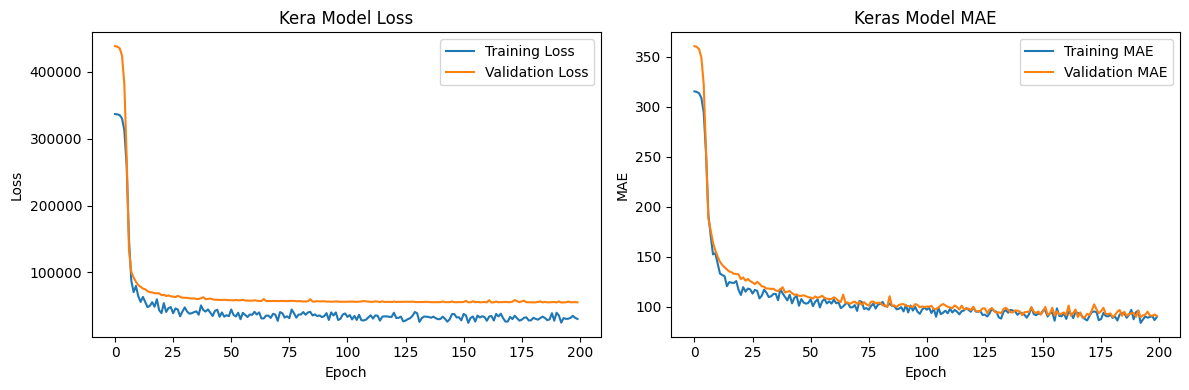

In [46]:
# Plot training history
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Kera Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Keras Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()

### 9. Comparison

In [47]:
# Comprehensive Performance Comparison
comparison_df = pd.DataFrame({
    'Model': ['XGBoost', 'SVM', 'Decision Tree', 'Random Forest', 'Sequence Model'],
    'Train_MSE': [xgb_train_mse, svm_train_mse, dt_train_mse, rf_train_mse, train_mse],
    'Test_MSE': [xgb_test_mse, svm_test_mse, dt_test_mse, rf_test_mse, test_mse],
    'Train_R2': [xgb_train_r2, svm_train_r2, dt_train_r2, rf_train_r2, train_r2],
    'Test_R2': [xgb_test_r2, svm_test_r2, dt_test_r2, rf_test_r2, test_r2],
    'Train_MAE': [xgb_train_mae, svm_train_mae, dt_train_mae, rf_train_mae, train_mae],
    'Test_MAE': [xgb_test_mae, svm_test_mae, dt_test_mae, rf_test_mae, test_mae]
})

print("COMPREHENSIVE MODEL PERFORMANCE COMPARISON")
print("=" * 80)
print(comparison_df.round(4))

# Find best model based on test R²
best_model_idx = comparison_df['Test_R2'].idxmax()
best_model = comparison_df.loc[best_model_idx, 'Model']
best_r2 = comparison_df.loc[best_model_idx, 'Test_R2']

print(f"\n🏆 BEST MODEL: {best_model}")
print(f"   Test R²: {best_r2:.4f}")
print(f"   Test MSE: {comparison_df.loc[best_model_idx, 'Test_MSE']:.2f}")
print(f"   Test MAE: {comparison_df.loc[best_model_idx, 'Test_MAE']:.2f}")

# Rank models by performance
print(f"\n📊 MODEL RANKING (by Test R²):")
ranking = comparison_df.sort_values('Test_R2', ascending=False)
for i, (idx, row) in enumerate(ranking.iterrows(), 1):
    print(f"{i}. {row['Model']}: R² = {row['Test_R2']:.4f}")

COMPREHENSIVE MODEL PERFORMANCE COMPARISON
            Model   Train_MSE     Test_MSE  Train_R2  Test_R2  Train_MAE  \
0         XGBoost  19111.5234   43859.6406    0.9242   0.8680    73.5157   
1             SVM  66280.2577  108604.3524    0.7372   0.6731    71.2793   
2   Decision Tree  22245.1151   51051.0062    0.9118   0.8463    55.7161   
3   Random Forest  12994.2409   31074.7172    0.9485   0.9065    39.8425   
4  Sequence Model  22358.6055   26348.4141    0.9113   0.9207    65.8077   

   Test_MAE  
0   89.4492  
1   94.4102  
2   82.2928  
3   61.1903  
4   67.0449  

🏆 BEST MODEL: Sequence Model
   Test R²: 0.9207
   Test MSE: 26348.41
   Test MAE: 67.04

📊 MODEL RANKING (by Test R²):
1. Sequence Model: R² = 0.9207
2. Random Forest: R² = 0.9065
3. XGBoost: R² = 0.8680
4. Decision Tree: R² = 0.8463
5. SVM: R² = 0.6731


In [48]:
import os
import joblib

# Define the directory to save models and scalers
model_dir = './saved_models'
scaler_dir = './saved_scalers'
os.makedirs(model_dir, exist_ok=True)
os.makedirs(scaler_dir, exist_ok=True)

# Define the file paths
MODEL_PATH = os.path.join(model_dir, 'sequence_model.keras')
SCALER_X_PATH = os.path.join(scaler_dir, "scaler_X.pkl")
SCALER_Y_PATH = os.path.join(scaler_dir, "scaler_y.pkl")

# Save the Keras model in the native Keras format
keras_model.save(MODEL_PATH)

# Save the fitted scaler for X
joblib.dump(scaler, SCALER_X_PATH)
joblib.dump(scaler, SCALER_Y_PATH)


print(f"Sequence Model saved to {MODEL_PATH}")
print(f"Scaler for X saved to {SCALER_X_PATH}")
print(f"Scaler for y saved to {SCALER_Y_PATH}")

Sequence Model saved to ./saved_models/sequence_model.keras
Scaler for X saved to ./saved_scalers/scaler_X.pkl
Scaler for y saved to ./saved_scalers/scaler_y.pkl


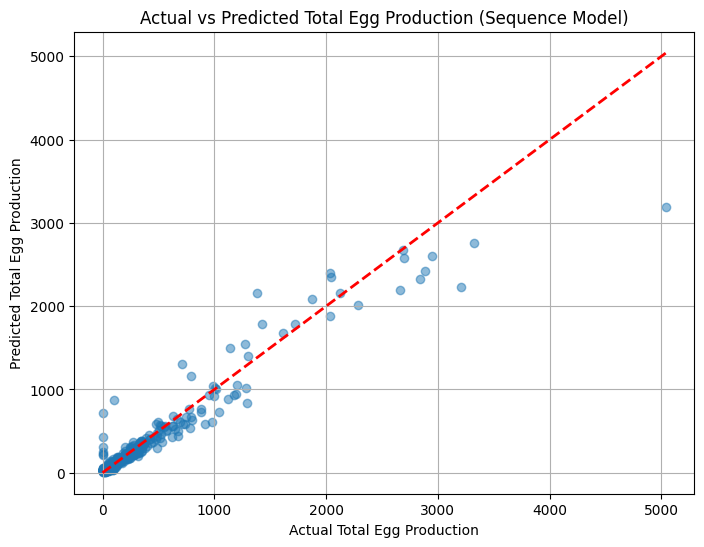

In [49]:
# Visualize predictions vs actual values for the best model (Sequence Model)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Total Egg Production')
plt.ylabel('Predicted Total Egg Production')
plt.title('Actual vs Predicted Total Egg Production (Sequence Model)')
plt.grid(True)
plt.show()

In [52]:
# Comprehensive Prediction Function using only the best model (Sequence Model)
def predict_egg_production(amount_chicken, ammonia, temperature,
                          humidity, light_intensity, Noise , Amount_of_Feeding):
    """
    Predict egg production based on input features using the best model (Sequence Model).

    Parameters:
    - amount_chicken: Number of chickens
    - ammonia: Ammonia level
    - temperature: Temperature
    - humidity: Humidity level
    - light_intensity: Light intensity
    - Noise: Noise level
    - Amount_of_Feeding: Amount of feeding

    Returns:
    - Predicted egg production
    """
    # Create input array
    input_data = np.array([[amount_chicken, Amount_of_Feeding, ammonia, temperature,
                           humidity, light_intensity, Noise ]])

    # Scale the input data using the pre-fitted scaler
    input_scaled = scaler.transform(input_data)

    # Make prediction using the Keras Sequence Model
    prediction = keras_model.predict(input_scaled)

    # Ensure prediction is a scalar integer for output
    predicted_eggs = int(prediction[0].item()) # Use .item() for scalar conversion

    return predicted_eggs

# Example prediction using the best model (Sequence Model)
print("\n" + "=" * 60)
print("PREDICTION EXAMPLE (Sequence Model)")
print("=" * 60)

# Example farm data
example_farm = {
    'amount_chicken': 1000,
    'Amount_of_Feeding': 200, # Added example value for Amount_of_Feeding
    'ammonia': 15,
    'temperature': 22,
    'humidity': 60,
    'light_intensity': 400,
    'Noise': 250 # Added example value for Noise
}

print("Example Farm Data:")
for key, value in example_farm.items():
    print(f"  {key}: {value}")


# Test with best model (Sequence Model)
sequence_pred = predict_egg_production(**example_farm)
print(f"\nSequence Model: {sequence_pred} eggs")

print(f"\n🎯 Recommended prediction: {sequence_pred} eggs (using Sequence Model)")


PREDICTION EXAMPLE (Sequence Model)
Example Farm Data:
  amount_chicken: 1000
  Amount_of_Feeding: 200
  ammonia: 15
  temperature: 22
  humidity: 60
  light_intensity: 400
  Noise: 250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

Sequence Model: 321 eggs

🎯 Recommended prediction: 321 eggs (using Sequence Model)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
